### Import packages

In [1]:
# Import packages
print("---------IMPORTING PACKAGES---------")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random
import csv
import time
import keras

from sklearn.utils import shuffle
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam, Adamax, SGD

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)


---------IMPORTING PACKAGES---------


### Define the changeable parameters

In [2]:
input_folder = "/kaggle/input/"
output_folder = "/kaggle/working/"
verbose = 1 # 0-> dont print training info, 1-> print them
n_epochs = 60

batch_size = 128
learn_rate = 0.0001
loss_fun = "mean_squared_logarithmic_error"
act_fun = "elu"
optmzer = Nadam(learning_rate=learn_rate)
n_convolutional_layers = 8
filter_size = (3,3)
filters_number = "NA"

params = [n_epochs,
          batch_size,
          loss_fun, 
          act_fun,
          learn_rate, 
          optmzer,
          n_convolutional_layers,
          filter_size
         ]

For the number of filters, it makes sense to increase gradually. So that you could leave as a more fixed variable. 
start with few to get the rough features (line direction) and increase afterwards to pick up on the more abstract details. But don't go too big, else comp complexity spikes up.

### Create a fine to save the results

In [3]:
# Open the excel file where I'll save all the test results (metrics)

with open("./results.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow(["experiment_ID",
                         "model_name", 
                         "n_epochs", # params[0]
                         "batch_size", # params[1]
                         "loss_function", # params[2]
                         "activation_fun", # params[3]
                         "learning_rate", # params[4]
                         "optimizer", # params[5]
                         "num_conv_layers", # params[6]
                         "kernel_size", # params[7]
                         "train_time_per_epoch",
                         "num_epochs_run", # epoch where it stopped automatically
                         "test_loss",
                         "test_accuracy",
                         "test_auc",
                         "wa_precision", # wa = weighted average
                         "wa_recall",
                         "wa_f1_score",
                         "wrong_preds",
                         "total_preds",
                         "num_train", # number of images in the training set
                         "num_val", # number of images in the validation set
                         "num_test" # number of images in the test set  
                        ])

### Define functions

In [4]:
# https://stackoverflow.com/questions/39280813/visualization-of-convolutional-layer-in-keras-model
# Merdan Memtimin https://stackoverflow.com/users/6565409/merdan-memtimin
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))
            
            
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


def flatten(d):
    v = [[i] if not isinstance(i, list) else flatten(i) for i in d]
    return [i for b in v for i in b]


def precision(confusion_matrix):
    """Given a confusion matrix, calculates and returns precision for all classes"""
    precision_list = []
    for i in range(confusion_matrix.shape[1]):
        current_col = confusion_matrix[:,[i]]
        current_el = confusion_matrix[i,[i]]
        current_precision = (float(current_el/sum(current_col)[0]))
        current_precision = round(current_precision, 4)
        precision_list.append(current_precision)
    return precision_list

def recall(confusion_matrix):
    """Given a confusion matrix, calculates and returns recall for all classes"""
    recall_list = []
    for i in range(confusion_matrix.shape[0]):
        current_row = confusion_matrix[i,:]
        current_el = confusion_matrix[i,i]
        current_recall = round(current_el/sum(current_row), 4)
        recall_list.append(current_recall)
    return(recall_list)

def f1_score(precision, recall):
    """Given a list of precision and recall values for a certain matrix,
    returns f-1 values for each class"""
    f1_scores = []
    if len(precision) == len(recall):
        for i in range(len(precision)):
            current_f1 = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
            f1_scores.append(round(current_f1, 4))
    else:
        print("Error. Precision and Recall lists should be of equal lengths.")
    return f1_scores


### Load data

In [5]:
print("---------LOADING DATA---------")
train_dir = "../input/landuse-scene-classification/images_train_test_val/train"
test_dir = "../input/landuse-scene-classification/images_train_test_val/test"
val_dir = "../input/landuse-scene-classification/images_train_test_val/validation"


train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)


# creating datasets

training_set = train_gen.flow_from_directory(train_dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 32
                                           )

test_set = test_gen.flow_from_directory(test_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         batch_size = 32
                                         )
validation_set = val_gen.flow_from_directory(val_dir,
                                       target_size = (224,224),
                                       class_mode = "categorical",
                                       batch_size = 32
                                       )

---------LOADING DATA---------
Found 7350 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [6]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

class_count = len(class_name_list)

class_count

21

### Preprocessing

### Build train, val, test sets

## Define Functions
### Compile and Fit

Define Time History class to record time taken per epoch.

In [7]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [8]:
def run_model(model, model_name, params):
    """
    Given a model architecture, the function compiles and fits the model.
    
    model: model architecture
    model_name: "str", name used as model description in the output file
    params: an array containing the values for the training parameters, namely:
    [n_epochs, batch_size, loss_fun, act_fun, learn_rate, optmzer]
    """
    # Path to save the model
    model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"
    # Save the weigths of the best model
    checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
    # Reduce learning rate when val_loss stops improving for 5 epochs.
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5)
    # Stop training if a val_loss has stopped improving for 8 epochs.
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=verbose)
    
    time_callback = TimeHistory()
    callback_list = [checkpoint, early_stopping, time_callback] #, reduce_lr]
    
    metrics=['accuracy',
             tf.keras.metrics.AUC(from_logits=True)]
    
    print("---------MODEL COMPILE---------")
    model.compile(loss=params[2],
                  optimizer=params[5],
                  metrics=metrics)

    print("---------MODEL FIT---------")
    
    history = model.fit(
        training_set,
        validation_data=validation_set,
        callbacks=callback_list,
        epochs=params[0],
        verbose=verbose,
    )
    
    times = time_callback.times
    avg_time_epoch = sum(times)/len(times)
    new_params = params
    new_params.append(avg_time_epoch)

    return history, new_params

### Get Evaluation Metrics

In [9]:
def get_eval_metrics(history, model, test_set, params):
    """
    Given a trained model and a test set, the function returns model eval metrics.
    
    
    """
    print("---------MODEL EVALUATE---------")
    
    n_ran_epochs = len(history.history['loss'])
    
    loss, accuracy, auc = model.evaluate(test_set, verbose=verbose)
    
    test_set.reset()
    predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=verbose)
    predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
    report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)
    wa_prec = report["weighted avg"]["precision"]
    wa_rec = report["weighted avg"]["recall"]
    wa_f1 = report["weighted avg"]["f1-score"]
    cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
    confusion_matrix_df = pd.DataFrame(
        data=cf_matrix, 
        index=class_name_list, 
        columns=class_name_list
    )
    results_df = pd.DataFrame(
        {
            "label": test_set.labels, 
            "prediction": predicted_class_ids, 
            "path": test_set.filepaths
        }
        )

    mistakes = results_df["label"] != results_df["prediction"]
    mistakes_df = results_df[mistakes]
    wrong_preds = len(mistakes_df)
    tot_preds = len(results_df)

    print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
    
    
    eval_metrics = [n_ran_epochs,
                   loss,
                   accuracy,
                   auc,
                   wa_prec,
                   wa_rec,
                   wa_f1,
                   wrong_preds,
                   tot_preds
        ]
    
    return eval_metrics, cf_matrix, confusion_matrix_df, results_df

### Save plots

In [10]:
def save_plots(history, output_folder, model_name, confusion_matrix_df):
    plt.subplot(1, 2, 1)
    # Loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss - " + model_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy - " + model_name)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    #plt.show()
    plt.savefig(output_folder + model_name + "_training_curves.png")
    
    # CONFUSION MATRIX IMAGE
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
    plt.ylabel("Label")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix - " + model_name)
    #plt.show()
    plt.savefig(output_folder + model_name + "_confusion.png")

### Save numerical results

In [11]:
def append_results_to_csv(csv_row):
    print("---------SAVE RESULTS---------")
    """Append the results to the csv file
    csv_row: list, contains the information to append to the csv"""
    
    with open("./results.csv", 'a+', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        # Create a row with the column names:
        filewriter.writerow(csv_row)


# EXPERIMENT VGG16-P1

# Optimizer Nadam

-------- EXPERIMENT VGG16-P1_Final ----------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
conv2d_5 (

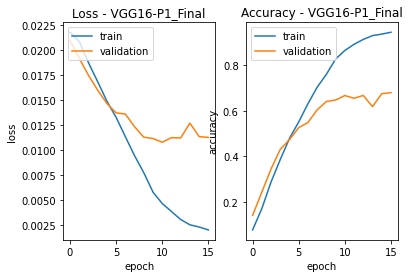

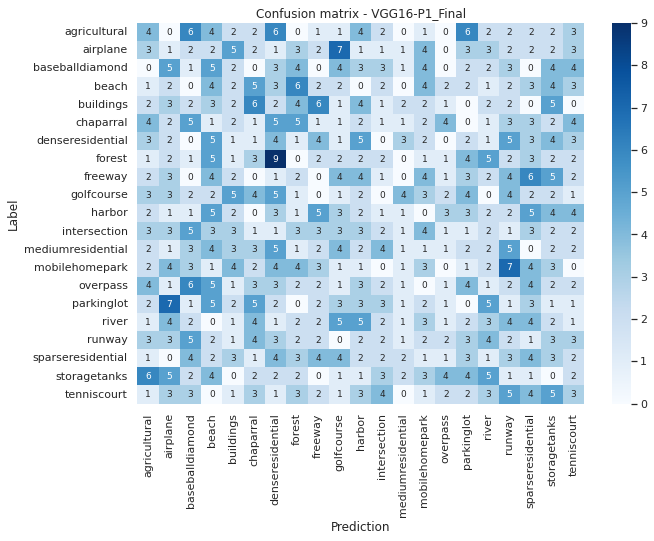

In [12]:
model_id = "VGG16-P1_Final"
model_name = model_id

print(f"-------- EXPERIMENT {model_id} ----------")

model = Sequential()

# start of model
model.add(Conv2D(input_shape=(224,224,3),filters=64, kernel_size=filter_size, padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=filter_size, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=filter_size, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
model.add(Conv2D(filters=128, kernel_size=filter_size, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=filter_size, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=filter_size, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=filter_size, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=filter_size, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


model.summary()


# Model COMPILE and FIT
history, new_params = run_model(model, model_name, params)
params = new_params
# Model EVALUATE
eval_metrics, cf_matrix, confusion_matrix_df, results_df = get_eval_metrics(history, model, test_set, params)

save_plots(history, output_folder, model_name, confusion_matrix_df)

params_to_save = params
params_to_save[7] = str(params_to_save[7]).replace(',', ";")

new_row = [model_id,
           model_name,
           params_to_save,
           eval_metrics,
           7350, # number of images in the training set
           1050, # number of images in the validation set
           2100, # number of images in the test set
          ]

new_row = flatten(new_row)

append_results_to_csv(new_row)
